connect drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [3]:
import os
import cv2 as cv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


Load and preprocess data

In [4]:
# Path to your dataset folder
data_path = '/content/drive/MyDrive/Animals'

# Get category names (folder names)
categories = [folder for folder in os.listdir(data_path)]
print("Found categories:", categories)

# Prepare data list: [image_array, class_index]
data = []
for idx, category in enumerate(categories):
    folder_path = os.path.join(data_path, category)
    print(f"Loading images for category: {category}")

    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

        if img is not None:
            img = cv.resize(img, (32, 32))
            data.append([img, idx])

print("Total images loaded:", len(data))


Found categories: ['cats', 'dogs', 'panda']
Loading images for category: cats


100%|██████████| 101/101 [00:03<00:00, 28.47it/s]


Loading images for category: dogs


100%|██████████| 101/101 [00:02<00:00, 43.22it/s]


Loading images for category: panda


100%|██████████| 101/101 [00:13<00:00,  7.72it/s]

Total images loaded: 300


Visualize few samples

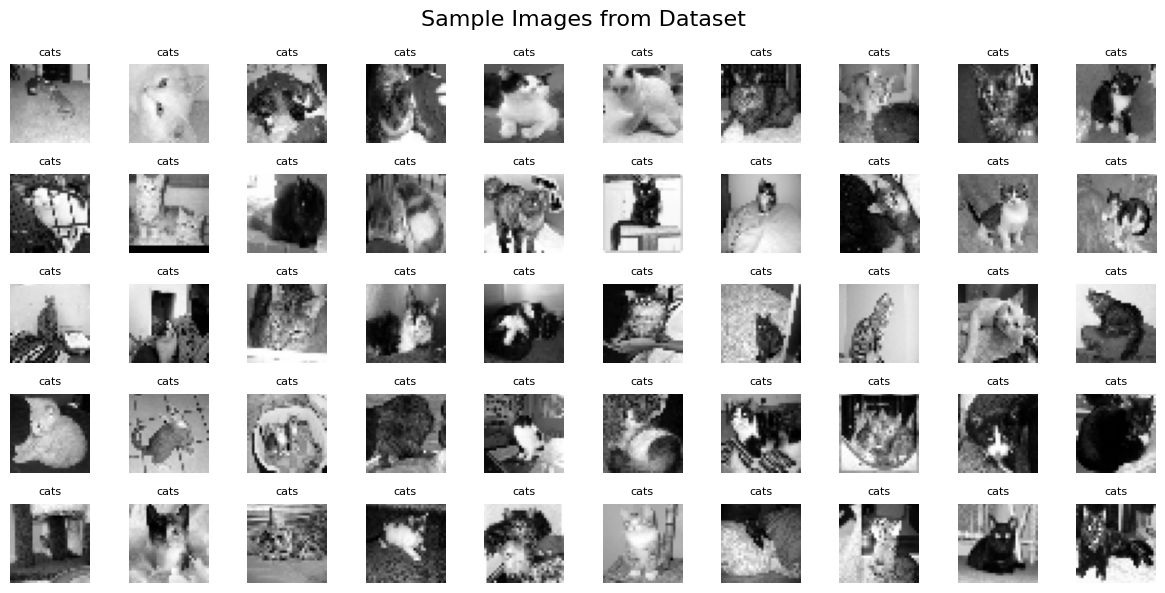

In [12]:
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(data[i][0], cmap='gray')
    plt.title(categories[data[i][1]], fontsize=8)
    plt.axis('off')

plt.suptitle('Sample Images from Dataset', fontsize=16)
plt.tight_layout()
plt.show()


Split into 5 folds manually

In [13]:
# Assuming dataset has ~300 images
fold_size = len(data) // 5
folds = [data[i*fold_size:(i+1)*fold_size] for i in range(5)]

for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))


Fold 1 size: 60
Fold 2 size: 60
Fold 3 size: 60
Fold 4 size: 60
Fold 5 size: 60


Define distance functions

In [14]:
def calc_l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def calc_l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))


Calculate distances to training set

In [15]:
k_max = 20

def compute_distances(train, val):
    l1_results, l2_results = [], []

    for v_img, v_label in tqdm(val, desc="Validating"):
        temp = []
        for t_img, t_label in train:
            temp.append([
                v_label, t_label,
                {"l1": calc_l1_distance(v_img, t_img), "l2": calc_l2_distance(v_img, t_img)}
            ])

        # Sort and keep top-k
        temp_sorted_l1 = sorted(temp, key=lambda x: x[2]["l1"])[:k_max]
        temp_sorted_l2 = sorted(temp, key=lambda x: x[2]["l2"])[:k_max]

        l1_results.append(temp_sorted_l1)
        l2_results.append(temp_sorted_l2)

    return l1_results, l2_results


Calculate accuracy for each k

In [16]:
def calc_accuracy(results, distance_type):
    accuracies = []

    for k in range(1, k_max+1):
        correct = 0

        for neighbors in results:
            top_k = neighbors[:k]
            true_label = top_k[0][0]

            # Count how many of top_k have the same label
            same = sum(1 for n in top_k if n[1] == true_label)

            # Simple voting: majority wins
            if same > k/2:
                correct += 1
        acc = correct / len(results)
        accuracies.append(acc)
    return accuracies


Cross-validation loop

In [17]:
all_accuracies = []

for fold_idx in range(5):
    print(f"\nProcessing Fold {fold_idx+1}...")

    # Prepare train/validation
    validation = folds[fold_idx]
    train = [img for i, f in enumerate(folds) if i != fold_idx for img in f]

    # Compute distances
    l1_results, l2_results = compute_distances(train, validation)

    # Compute accuracies
    l1_acc = calc_accuracy(l1_results, "l1")
    l2_acc = calc_accuracy(l2_results, "l2")

    all_accuracies.append([l1_acc, l2_acc])



Processing Fold 1...


Validating: 100%|██████████| 60/60 [00:00<00:00, 250.70it/s]



Processing Fold 2...


Validating: 100%|██████████| 60/60 [00:00<00:00, 236.61it/s]



Processing Fold 3...


Validating: 100%|██████████| 60/60 [00:00<00:00, 262.40it/s]



Processing Fold 4...


Validating: 100%|██████████| 60/60 [00:00<00:00, 246.80it/s]



Processing Fold 5...


Validating: 100%|██████████| 60/60 [00:00<00:00, 261.57it/s]


L1 Distance

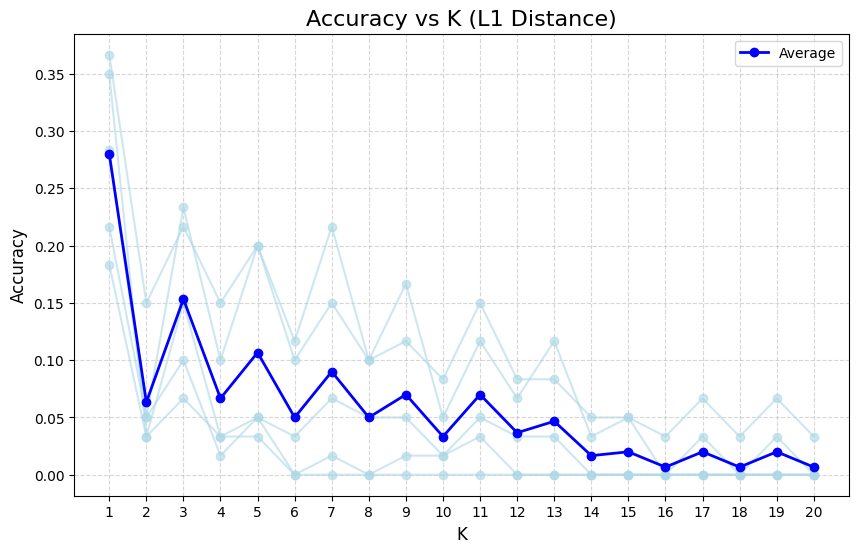

In [20]:
plt.figure(figsize=(10, 6))
k_values = list(range(1, k_max+1))

# Plot each fold as light lines
for fold in all_accuracies:
    plt.plot(k_values, fold[0], color='lightblue',marker='o', alpha=0.6)

# Plot average trend
mean_l1 = np.mean([fold[0] for fold in all_accuracies], axis=0)
plt.plot(k_values, mean_l1, color='blue', marker='o', linewidth=2, label='Average')

plt.title('Accuracy vs K (L1 Distance)', fontsize=16)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


L2 Distance

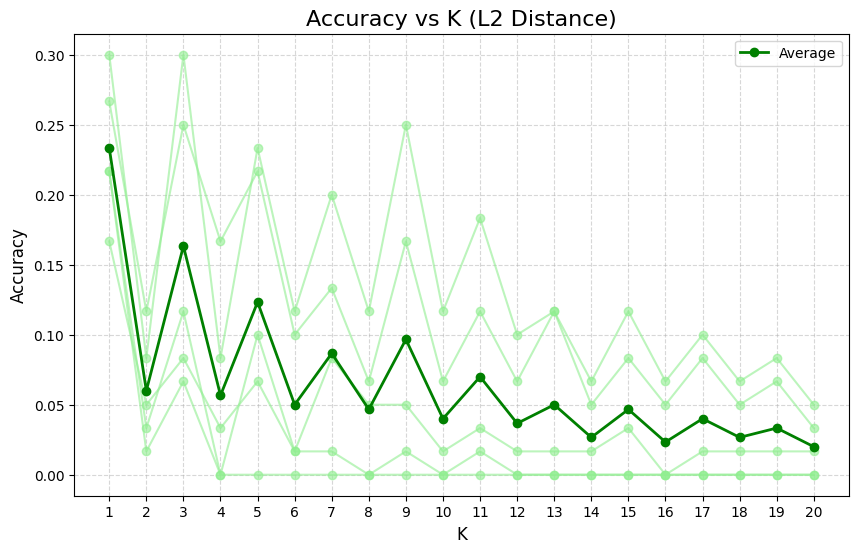

In [21]:
plt.figure(figsize=(10, 6))

for fold in all_accuracies:
    plt.plot(k_values, fold[1], color='lightgreen',marker='o', alpha=0.6)

mean_l2 = np.mean([fold[1] for fold in all_accuracies], axis=0)
plt.plot(k_values, mean_l2, color='green', marker='o', linewidth=2, label='Average')

plt.title('Accuracy vs K (L2 Distance)', fontsize=16)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
